In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath , groutine

In [2]:
def get_intensity_and_reflectivity(thickness, polarization, pulse_duration = 2., adjust=1e-6):
    ###################################################################
    #  Set Pulse
    ###################################################################
    energy_center = 10.
    pre_length = 1e6

    # Set up the pulse
    FWHM = 50 # (um)

    my_pulse = pulse.GaussianPulse3D()
    my_pulse.set_pulse_properties(central_energy=energy_center,
                                  polar=polarization,
                                  sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                                  sigma_z=pulse_duration,
                                  x0=np.array([0., 0., -pre_length]))
    
    #-----------------------------------------------------------------
    #  Set Crystal
    #-----------------------------------------------------------------
    # Some meta data for the delay line.
    h_length = 2. * np.pi / (0.89170 * 1e-4)

    # Some crystal properties
    chi0 = complex(-0.14606E-04, 0.12304E-07)
    chih_sigma = complex(0.36477E-05, -0.11228E-07)
    chihbar_sigma = chih_sigma
    chih_pi = complex(0.12169E-06, -0.71046E-09)
    chihbar_pi = chih_pi

    # Bragg angle
    bragg = np.radians(44.044) + adjust

    # Get crystal angles
    eta_b1 = np.zeros(1, dtype=np.float64)
    theta_b1 = np.array([3 * np.pi / 2 - bragg,])
    rho_b1 = theta_b1 + np.pi
    tau_b1 = np.zeros(1)


    # Initialize the crystals
    crystal_list_1 = lclsutil.get_crystal_list(num=1,
                                               hlen=np.array([h_length, ]),
                                               theta=theta_b1,
                                               eta=eta_b1,
                                               rho=rho_b1,
                                               tau=tau_b1,
                                               chi0=chi0,
                                               chih_sigma=chih_sigma,
                                               chihbar_sigma=chihbar_sigma,
                                               chih_pi=chih_pi,
                                               chihbar_pi=chihbar_pi)
    crystal_list_1[0].set_thickness(thickness)
    
    ###################################################################
    #  Rotate the pulse
    ###################################################################
    # Get kout
    kout_c = util.get_bragg_kout(kin = my_pulse.k0, 
                                 h=crystal_list_1[0].h,
                                 normal=crystal_list_1[0].normal)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Get the observation point
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    observation = kout_c * 1e6 / util.l2_norm(kout_c)
    total_path = pre_length + 1e6
    print("The total propagation length is {:.2f}m.".format(total_path / 1e6))

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #                  Change frame
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # find the rotation matrix to find the proper frame
    tmp = np.arctan(kout_c[1] / kout_c[2])
    rot_tmp = Rotation.from_euler('x', tmp)

    (my_pulse,
     observation,
     [crystal_list_1,]
    ) = lclsutil.get_intermediate_frame(displacement=np.zeros(3),
                                        rotation= rot_tmp.as_dcm(),
                                        observe=observation,
                                        pulse=my_pulse,
                                        crystal_lists = [crystal_list_1,])

    ###################################################################
    #  Get the momentum mesh
    ###################################################################
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #                  
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    number_x = 2
    number_y = 2
    number_z = 10 ** 5
    kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=5e-4,
                                                              delta_e_z=2e-3)
    kz_grid += my_pulse.klen0

    # Apply fft shift
    # kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
    kx_grid = np.zeros(1, np.float64)
    number_x = 1
    ky_grid = np.zeros(1, np.float64)
    number_y = 1
    kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))
    
    ###################################################################
    #  Get the output field
    ###################################################################
    # Set the range of the index to save
    z_idx_range = 400
    num1 = 350
    num2 = 50
    d_num = 512

    crystal_list = crystal_list_1

    # -------------------------------------------------------------
    #            Get Field for variable branch
    # -------------------------------------------------------------
    tic = time.time()

    (result_3d_var,
     result_2d_var,
     check_var
    ) = groutine.get_diffraction_field(crystal_list = crystal_list,
                                       total_path = total_path, 
                                       observation = observation,
                                       my_pulse = my_pulse,
                                       kx_grid = kx_grid,
                                       ky_grid = ky_grid,
                                       kz_grid = kz_grid,
                                       pulse_delay_time = 0.,
                                       pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                       grating_orders = [0,],
                                       number_x = number_x,
                                       number_y = number_y,
                                       number_z = number_z,
                                       z_idx_range = z_idx_range,
                                       idx_start_1=number_z - num1,
                                       idx_start_2=0,
                                       num1 = num1,
                                       num2 = num2, 
                                       d_num = 512)

    toc = time.time()
    print("It takes {:.2f} seconds to get the field for {} um.".format((toc - tic), thickness))
    
    return [check_var['reflectivity_sigma'],
            check_var['reflectivity_pi'],
            check_var['x_field'],
            check_var['y_field'],
            check_var['z_field'],
           axis_info]

# Get transformation limited pulse duration

In [3]:
[reflect_sigma,
 reflect_pi,
 x_field, 
 y_field, 
 z_field,
 axis_info] = get_intensity_and_reflectivity(thickness = 20, polarization = [1., 0., 0.], adjust=1.8e-5)

The total propagation length is 2.00m.
It takes 0.05 seconds to prepare the variables.
It takes 0.31 seconds to get the field for 20 um.


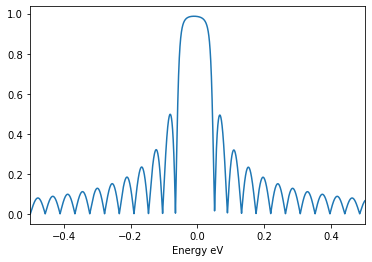

In [4]:
plt.plot(axis_info["energy_grid_z"] * 1000, np.fft.ifftshift(np.abs(reflect_sigma)))
plt.xlim([-0.5, 0.5])
plt.xlabel("Energy eV")
plt.show()

In [5]:
np.max(np.square(np.fft.ifftshift(np.abs(reflect_sigma))))

0.9743101623027092

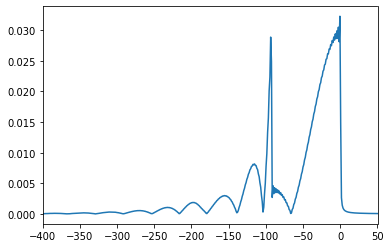

In [6]:
plt.plot(axis_info["z_time_idx"], np.fft.ifftshift(np.abs(np.fft.ifft(reflect_sigma))))
plt.xlim([-400, 50])
plt.show()

In [7]:
# Calculate the sigma of this distribution
distribution = np.square(np.fft.ifftshift(np.abs(np.fft.ifft(reflect_sigma))))

# Normalize
distribution /= np.sum(distribution)

# Get average
mean = np.sum(np.multiply(axis_info["z_time_idx"], distribution ))
l2_square = np.sum(np.multiply(np.square(axis_info["z_time_idx"]), distribution ))
std = np.sqrt(l2_square - mean ** 2)

print("The sigma of this distribution is {:.2f} fs.".format(std))

The sigma of this distribution is 35.31 fs.


# Get different distribution for different thickness

In [8]:
thickness_list = [5., 10., 20., 30., 50., 200., 1e6]

# Get the number of thickness values
num = len(thickness_list)

reflect_sigma_list = np.zeros((num, 10 ** 5), dtype = np.complex128)
reflect_pi_list= np.zeros((num, 10 ** 5), dtype = np.complex128)
field_list= np.zeros((num, 10 ** 5), dtype = np.complex128)

for x in range(num):
    [reflect_sigma_list[x,:],
     reflect_pi_list[x,:],
     field_list[x,:], 
     _, 
     _,
     axis_info] = get_intensity_and_reflectivity(thickness = thickness_list[x],
                                                 polarization = [1., 0., 0.],
                                                 pulse_duration = std, adjust=1.8e-5)

The total propagation length is 2.00m.
It takes 0.03 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 5.0 um.
The total propagation length is 2.00m.
It takes 0.05 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 10.0 um.
The total propagation length is 2.00m.
It takes 0.05 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 20.0 um.
The total propagation length is 2.00m.
It takes 0.03 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 30.0 um.
The total propagation length is 2.00m.
It takes 0.03 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 50.0 um.
The total propagation length is 2.00m.
It takes 0.03 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 200.0 um.
The total propagation length is 2.00m.
It takes 0.05 seconds to prepare the variables.
It takes 0.08 seconds to get the field for 1000000.0 um.


# Visualization

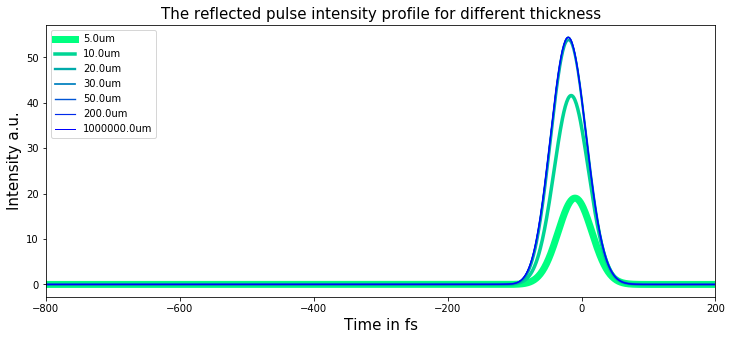

In [38]:
from matplotlib.pyplot import cm
import numpy as np

#variable n below should be number of curves to plot
color=cm.winter(np.linspace(1,0,num))

plt.figure(figsize=(12, 5))

for x in range(num):
    plt.plot(axis_info["z_time_idx"], 
             np.square(np.fft.ifftshift(np.abs(field_list[x])))/1e10, 
             c = color[x],
             lw = num / (x + 1),
             label="{}um".format(thickness_list[x]))

plt.legend(loc="upper left")
plt.title("The reflected pulse intensity profile for different thickness", fontsize=15)
plt.xlim([-800, 200])
#plt.ylim([17, 28])
plt.xlabel("Time in fs", fontsize=15)
plt.ylabel("Intensity a.u.", fontsize=15)
plt.savefig("C:/Users/haoyuan/Desktop/Intensity.png")
plt.show()

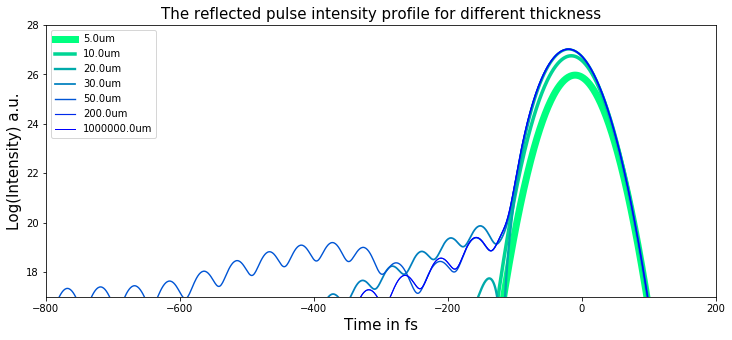

In [39]:
#variable n below should be number of curves to plot
color=cm.winter(np.linspace(1,0,num))

plt.figure(figsize=(12, 5))

for x in range(num):
    plt.plot(axis_info["z_time_idx"], 
             np.log(np.square(np.fft.ifftshift(np.abs(field_list[x])))), 
             c = color[x],
             lw = num / (x + 1),
             label="{}um".format(thickness_list[x]))

plt.legend(loc="upper left")
plt.title("The reflected pulse intensity profile for different thickness", fontsize=15)
plt.xlim([-800, 200])
plt.ylim([17, 28])
plt.xlabel("Time in fs", fontsize=15)
plt.ylabel("Log(Intensity) a.u.", fontsize=15)
plt.savefig("C:/Users/haoyuan/Desktop/Intensity_log.png")
plt.show()

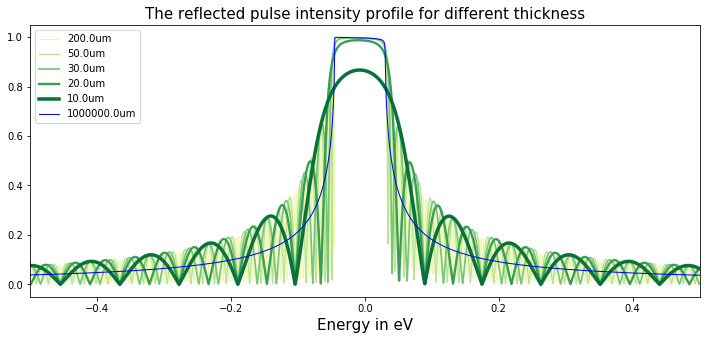

In [40]:
#variable n below should be number of curves to plot
color=cm.YlGn(np.linspace(1,0,num))

plt.figure(figsize=(12, 5))

for x in range(num - 2, 0, -1):
    plt.plot(axis_info["energy_grid_z"] * 1000,
             np.fft.ifftshift(np.abs(reflect_sigma_list[x])), 
             c = color[x],
             lw = num / (x + 1),
             label="{}um".format(thickness_list[x]))

plt.plot(axis_info["energy_grid_z"] * 1000,
         np.fft.ifftshift(np.abs(reflect_sigma_list[-1])), 
         c = 'blue',
         lw = 1,
         label="{}um".format(thickness_list[-1]))

plt.legend(loc="upper left")
plt.title("The reflected pulse intensity profile for different thickness", fontsize=15)
plt.xlim([-0.5, 0.5])
plt.xlabel("Energy in eV", fontsize=15)
plt.savefig("C:/Users/haoyuan/Desktop/Reflectivity.png")
plt.show()